In [34]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from time import strftime

In [25]:
PREDICTION_SUBMISSION_DIR = 'predictions_submission/'
PATCH_THRESHOLD = 0.4

In [26]:
predictions = []
for i in range(1, 51):
    image_filename = f'{PREDICTION_SUBMISSION_DIR}gt_{i}.png'
    im = mpimg.imread(image_filename)
    predictions.append(im)

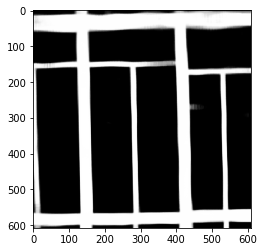

In [27]:
plt.imshow(predictions[0])
plt.show()

In [28]:
# CODE ERIC
# assign a label to a patch
def patch_to_label(patch, patch_threshold = 0.25):
  return 1 if np.mean(patch) > patch_threshold else 0


def create_image_label(im):
    """Reads a single image and outputs the strings that should go into the submission file"""
    patch_size = 16
    img = np.ones((38,38))
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, PATCH_THRESHOLD)
            #yield("{:03d}_{}_{},{}".format(img_number, j, i, label))
            img[j//patch_size,i//patch_size] = label
    return img

def create_labels(pred):
    imgs= []
    for i, im in enumerate(pred):
        imgs.append(create_image_label(im))
    return imgs
imgs = create_labels(predictions)

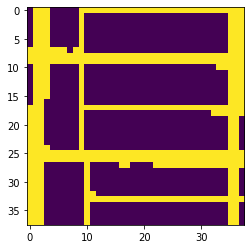

In [29]:
plt.imshow(imgs[0])
plt.show()

In [30]:
# code ERIC

from scipy import signal
def postprocess(img):
    """ Postprocessing of the predictions
    Modify isolated patchs """
    [dim_x, dim_y] = img.shape
    kernel = np.ones((3,3),np.float32)
    kernel[1,1] = 0

    
    kernel_hor = np.asarray(
        [
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [1,1,1,0,1,1,1],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0]
         ])
    kernel_hor_3 = kernel_hor[:3,:3]
    kernel_hor_3[1,1] = 0
    kernel_ver = np.asarray(
      [
        [0,0,0,1,0,0,0],
        [0,0,0,1,0,0,0],
        [0,0,0,1,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,0,1,0,0,0],
        [0,0,0,1,0,0,0],
        [0,0,0,1,0,0,0]
        ])
    kernel_ver_3 = kernel_ver[:3,:3]
    kernel_ver_3[1,1] = 0
    kernel_diag1 = np.asarray(
        [
         [1,0,0,0,0,0,0],
         [0,1,0,0,0,0,0],
         [0,0,1,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,1,0,0],
         [0,0,0,0,0,1,0],
         [0,0,0,0,0,0,1]
         ])
    
    kernel_diag2 = np.asarray(
        [
         [0,0,0,0,0,0,1],
         [0,0,0,0,0,1,0],
         [0,0,0,0,1,0,0],
         [0,0,0,0,0,0,0],
         [0,0,1,0,0,0,0],
         [0,1,0,0,0,0,0],
         [1,0,0,0,0,0,0]
         ])
    postprocess_img = img.copy()
    for z in range(2):
      filtered_img = signal.convolve2d(postprocess_img, kernel,mode ="same",boundary = 'symm')
      for i in range(0, dim_y):
          for j in range(0, dim_x):
            if img[i,j] == 1:
              if filtered_img[i,j] < 1 :
                        postprocess_img[i,j] = 0
            else:
              if filtered_img[i,j] > 7 :
                postprocess_img[i,j] = 1

      filtered_img_hor = signal.convolve2d(postprocess_img, kernel_hor,mode ="same",boundary = 'symm')
      filtered_img_ver = signal.convolve2d(postprocess_img, kernel_ver,mode ="same",boundary = 'symm')  
      filtered_img_hor_3 = signal.convolve2d(postprocess_img, kernel_hor_3,mode ="same",boundary = 'symm')
      filtered_img_ver_3 = signal.convolve2d(postprocess_img, kernel_ver_3,mode ="same",boundary = 'symm') 
      filtered_img_diag1 = signal.convolve2d(postprocess_img, kernel_diag1,mode ="same",boundary = 'symm')
      filtered_img_diag2 = signal.convolve2d(postprocess_img, kernel_diag2,mode ="same",boundary = 'symm')
    
      for i in range(0, dim_y):
          for j in range(0, dim_x):
              if img[i,j] == 1:
                  
                  if (filtered_img_hor[i,j] < 2) and  (filtered_img_ver[i,j] < 2) and (filtered_img_diag2[i,j] <3) and (filtered_img_diag1[i,j] <3):
                      postprocess_img[i,j] = 0
                  elif (filtered_img_ver[i,j] < 2) and  (filtered_img_hor[i,j] < 2) and (filtered_img_diag2[i,j] <3) and (filtered_img_diag1[i,j] <3):
                      postprocess_img[i,j] = 0
                  

              if img[i,j] == 0:

                  if ((filtered_img_ver[i,j] == 6)) or (filtered_img_hor[i,j] == 6):
                    postprocess_img[i,j] = 1

                  if (filtered_img_diag1[i,j] >4) or (filtered_img_diag2[i,j] >4):
                    if (filtered_img_ver[i,j] == filtered_img_ver_3[i,j]) and  (filtered_img_hor[i,j] == filtered_img_hor_3[i,j]):
                      postprocess_img[i,j] = 1

                  if j != 0 and j != dim_y and (filtered_img_hor[i,j] > 4) and  (filtered_img_ver[i,j] < 2):
                      postprocess_img[i,j] = 1
                  if i != 0 and i != dim_x and (filtered_img_ver[i,j] > 4) and  (filtered_img_hor[i,j] < 2):
                      postprocess_img[i,j] = 1
                  
                 

    return postprocess_img

<Figure size 432x288 with 0 Axes>

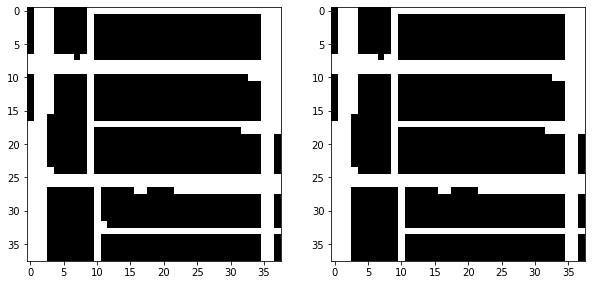

<Figure size 432x288 with 0 Axes>

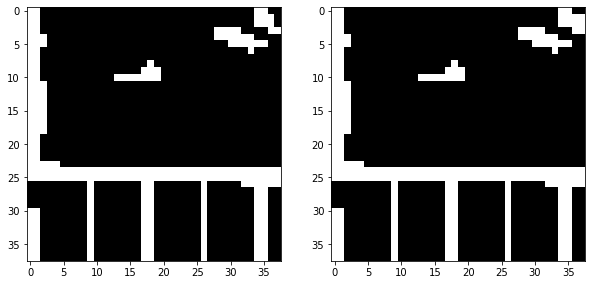

<Figure size 432x288 with 0 Axes>

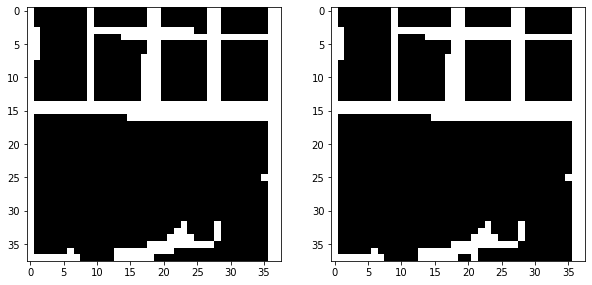

<Figure size 432x288 with 0 Axes>

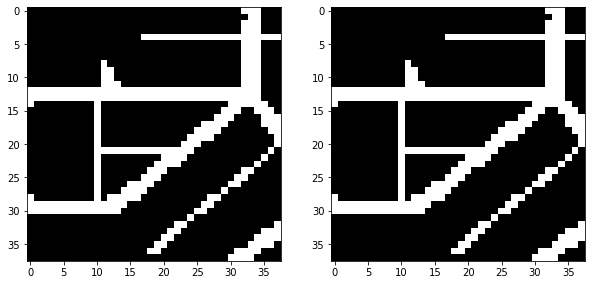

<Figure size 432x288 with 0 Axes>

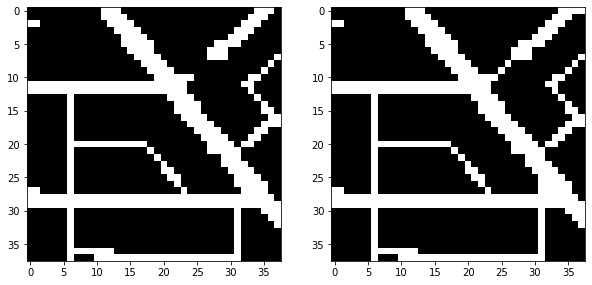

<Figure size 432x288 with 0 Axes>

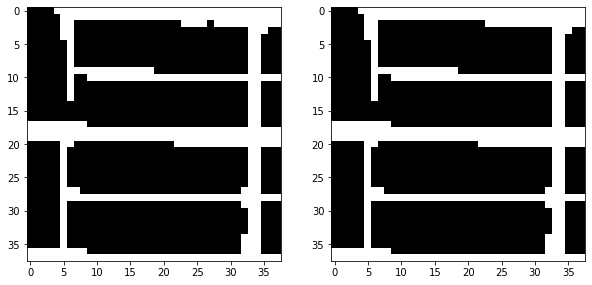

<Figure size 432x288 with 0 Axes>

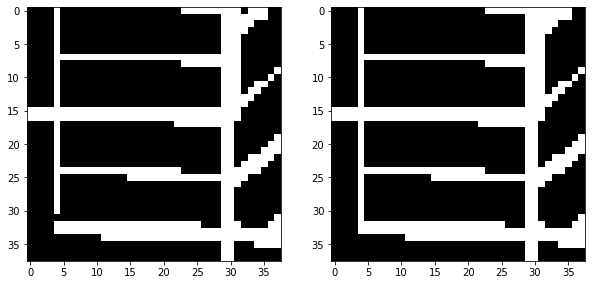

<Figure size 432x288 with 0 Axes>

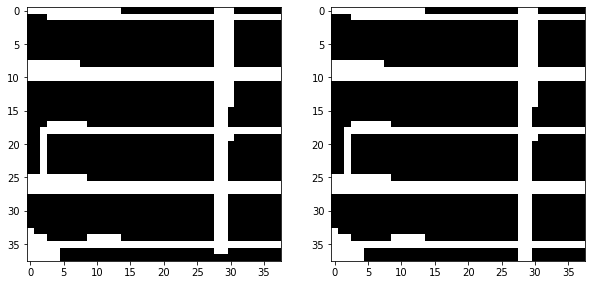

<Figure size 432x288 with 0 Axes>

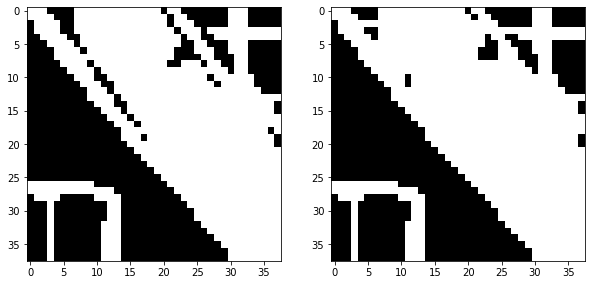

<Figure size 432x288 with 0 Axes>

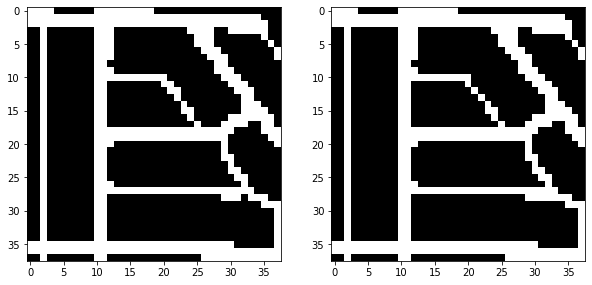

<Figure size 432x288 with 0 Axes>

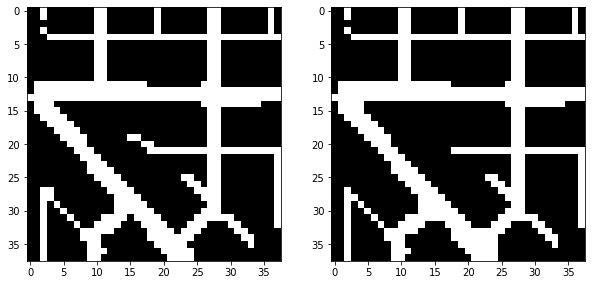

<Figure size 432x288 with 0 Axes>

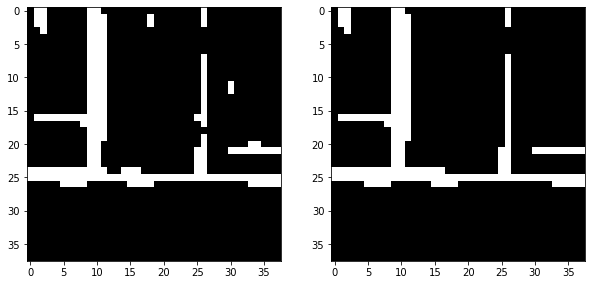

<Figure size 432x288 with 0 Axes>

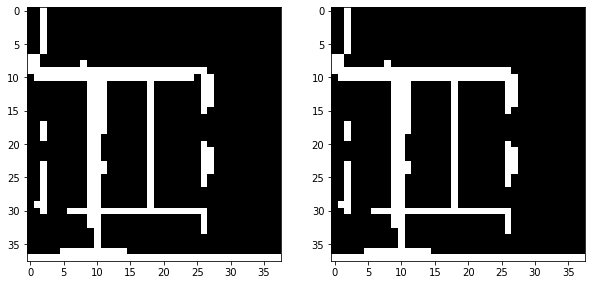

<Figure size 432x288 with 0 Axes>

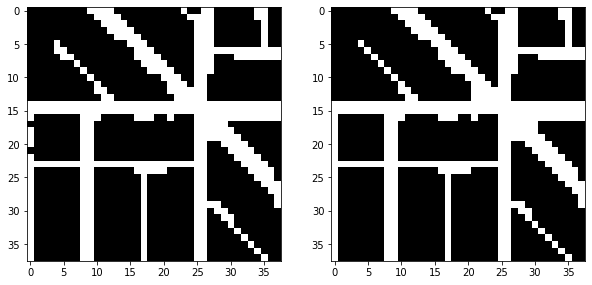

<Figure size 432x288 with 0 Axes>

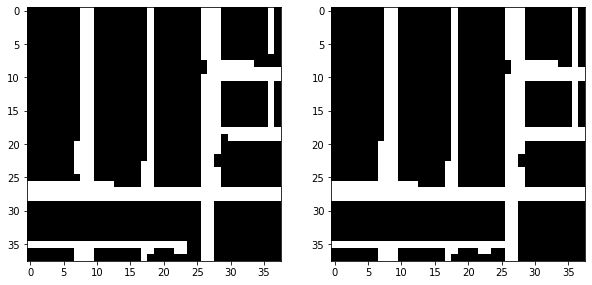

<Figure size 432x288 with 0 Axes>

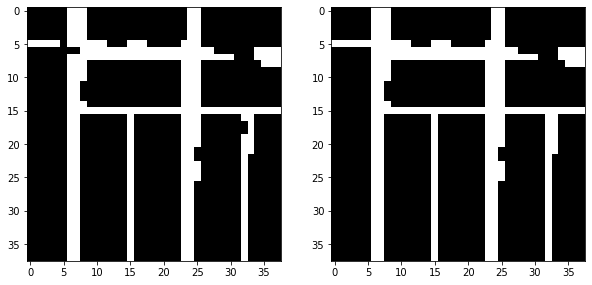

<Figure size 432x288 with 0 Axes>

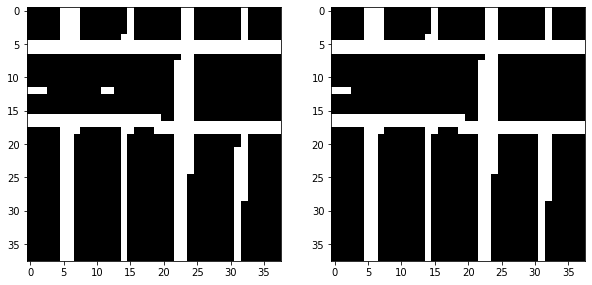

<Figure size 432x288 with 0 Axes>

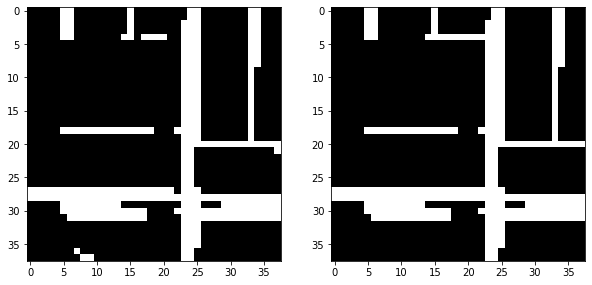

<Figure size 432x288 with 0 Axes>

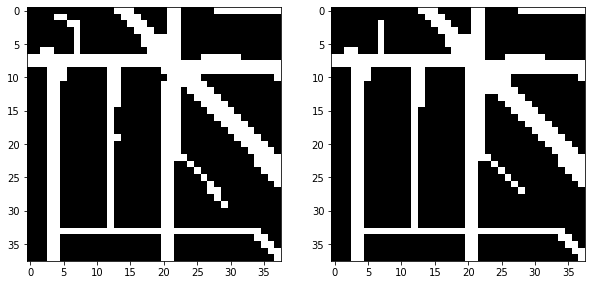

<Figure size 432x288 with 0 Axes>

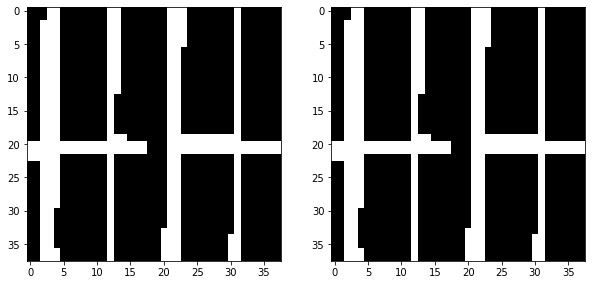

<Figure size 432x288 with 0 Axes>

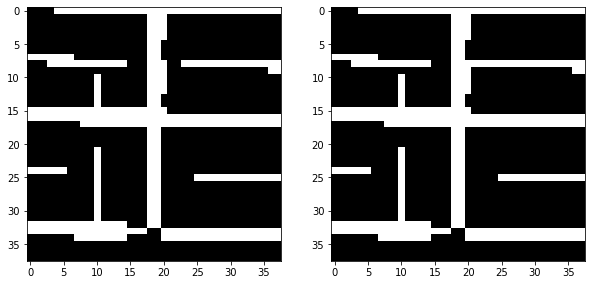

<Figure size 432x288 with 0 Axes>

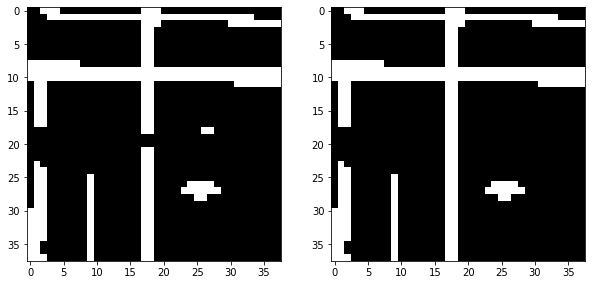

<Figure size 432x288 with 0 Axes>

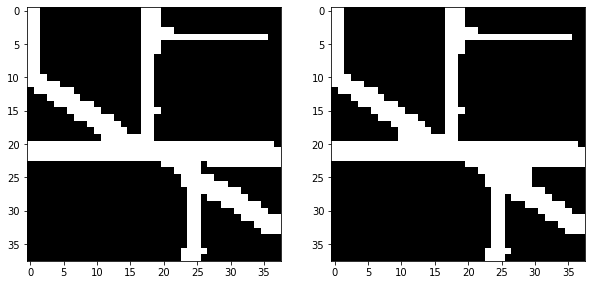

<Figure size 432x288 with 0 Axes>

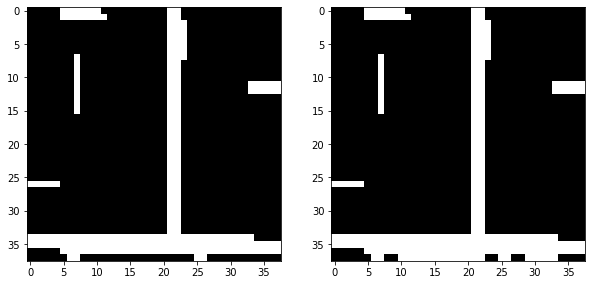

<Figure size 432x288 with 0 Axes>

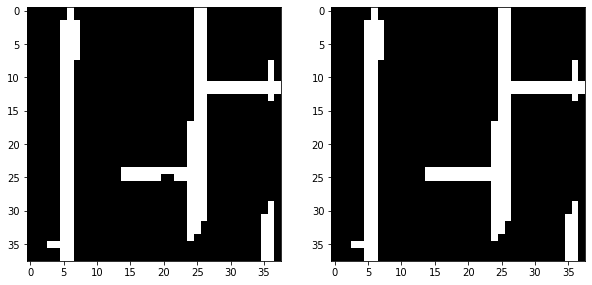

<Figure size 432x288 with 0 Axes>

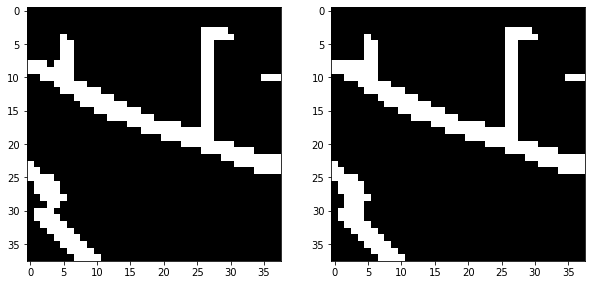

<Figure size 432x288 with 0 Axes>

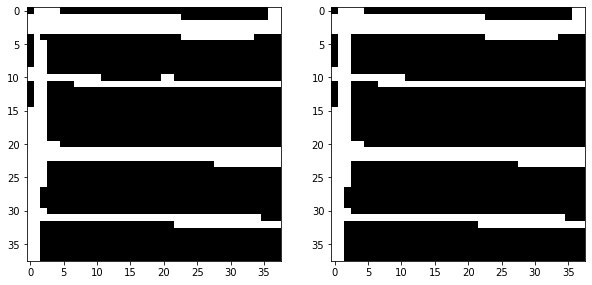

<Figure size 432x288 with 0 Axes>

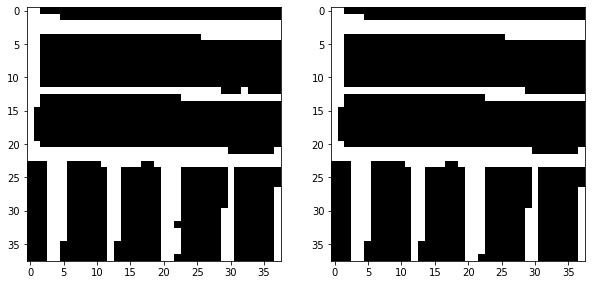

<Figure size 432x288 with 0 Axes>

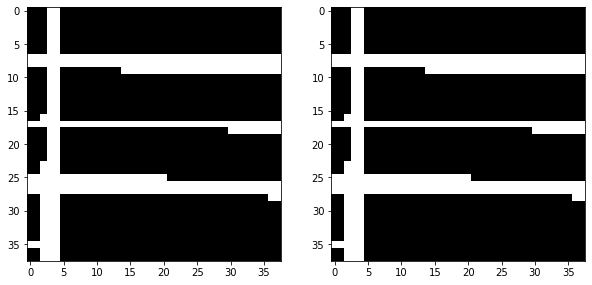

<Figure size 432x288 with 0 Axes>

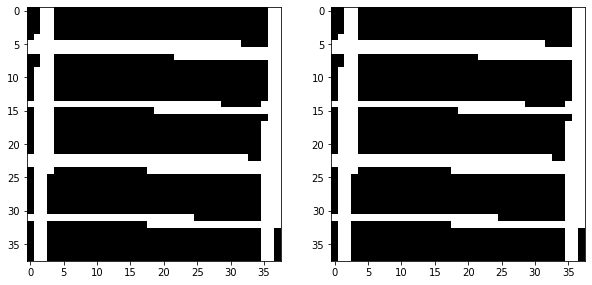

<Figure size 432x288 with 0 Axes>

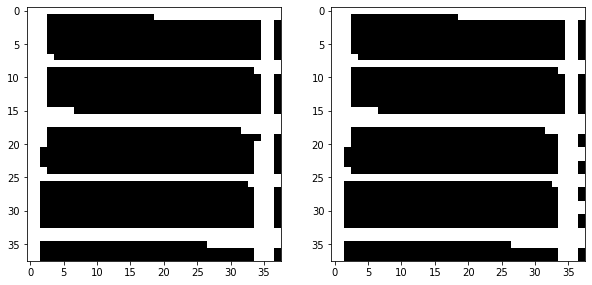

<Figure size 432x288 with 0 Axes>

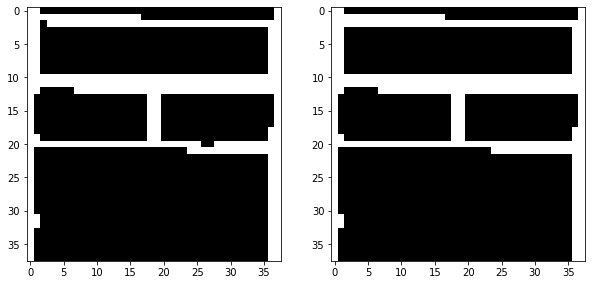

<Figure size 432x288 with 0 Axes>

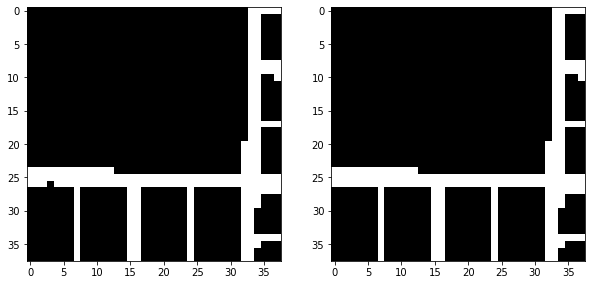

<Figure size 432x288 with 0 Axes>

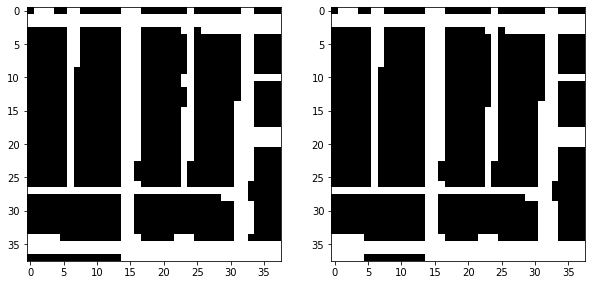

<Figure size 432x288 with 0 Axes>

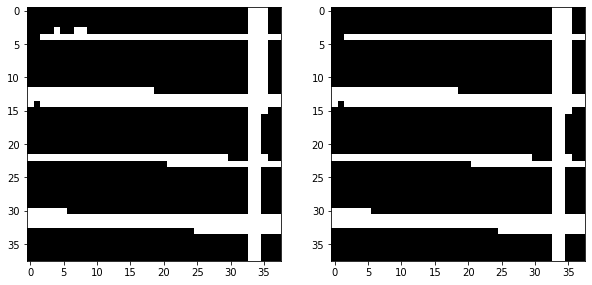

<Figure size 432x288 with 0 Axes>

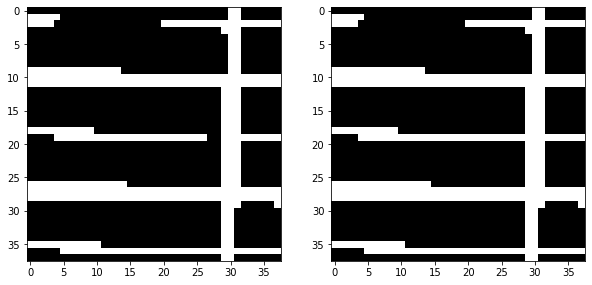

<Figure size 432x288 with 0 Axes>

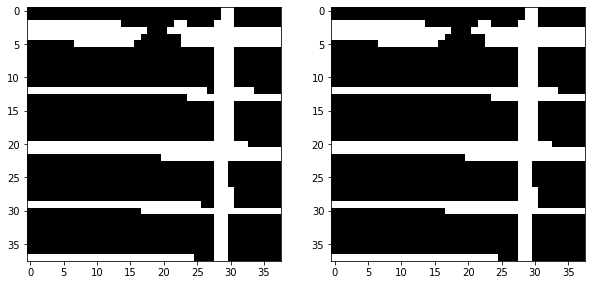

<Figure size 432x288 with 0 Axes>

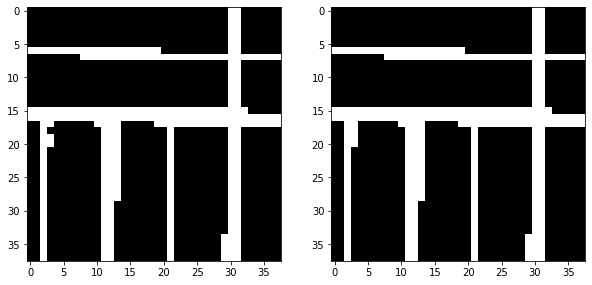

<Figure size 432x288 with 0 Axes>

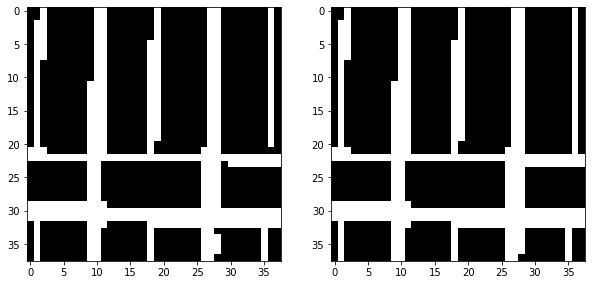

<Figure size 432x288 with 0 Axes>

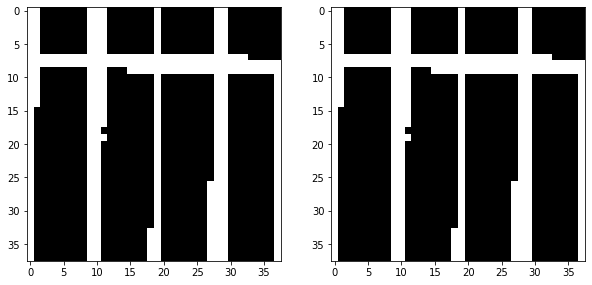

<Figure size 432x288 with 0 Axes>

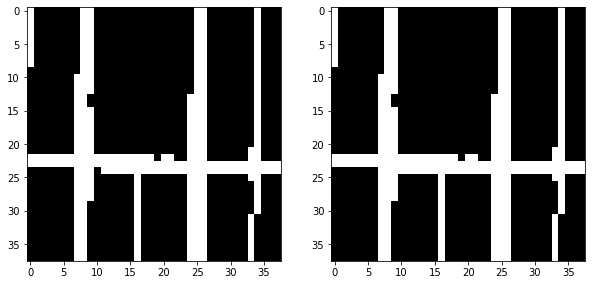

<Figure size 432x288 with 0 Axes>

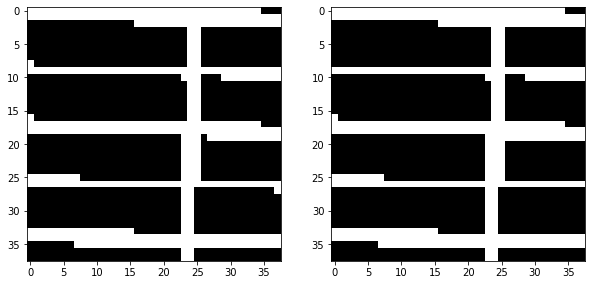

<Figure size 432x288 with 0 Axes>

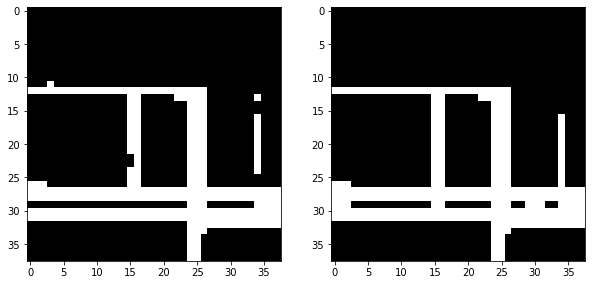

<Figure size 432x288 with 0 Axes>

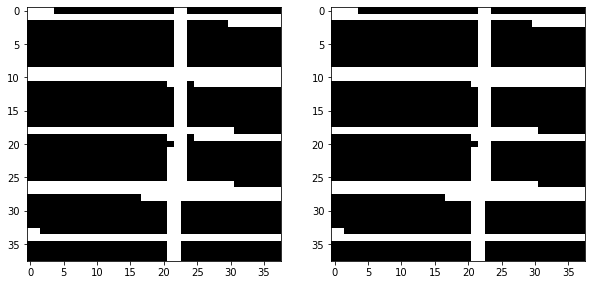

<Figure size 432x288 with 0 Axes>

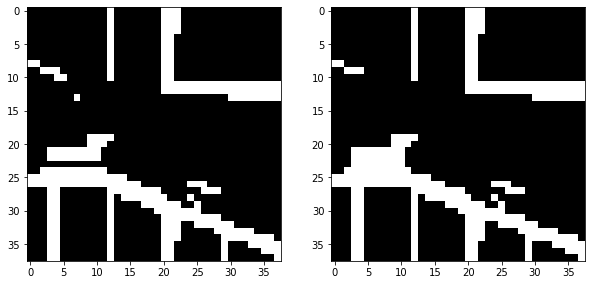

<Figure size 432x288 with 0 Axes>

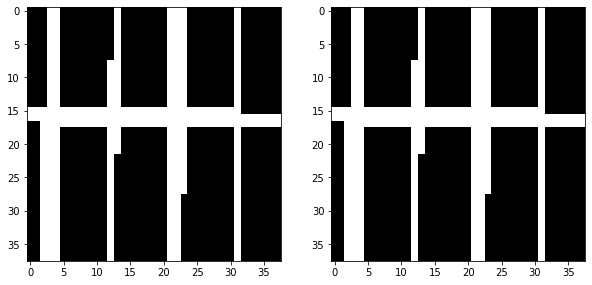

<Figure size 432x288 with 0 Axes>

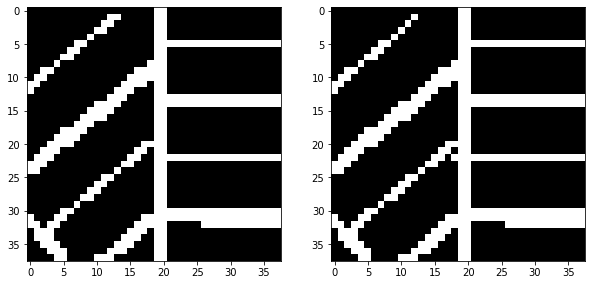

<Figure size 432x288 with 0 Axes>

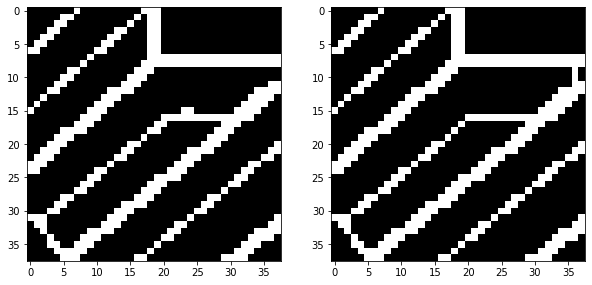

<Figure size 432x288 with 0 Axes>

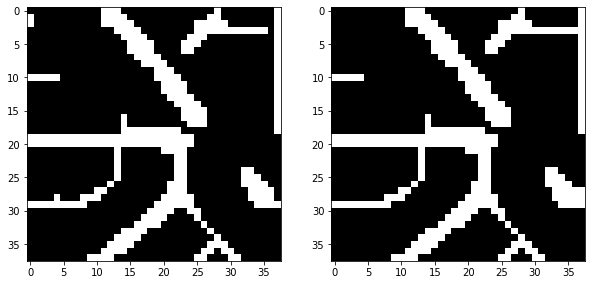

<Figure size 432x288 with 0 Axes>

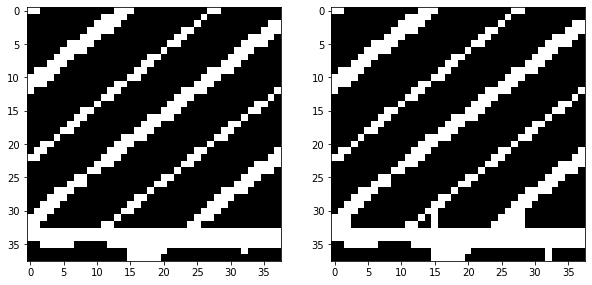

In [31]:
# CODE ERIC
postprocesses = []
for i in range(len(imgs)):
  plt.clf()
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1,2,1)
  ax.imshow(imgs[i],cmap="gray")
  ax = fig.add_subplot(1,2,2)
  pp = postprocess(imgs[i])
  postprocesses.append(pp)
  ax.imshow(pp,cmap="gray")
  #ax = fig.add_subplot(1,3,3)
  #ax.imshow(postprocess(p),cmap="gray")
  plt.show()

In [32]:
# CODE ERIC 
def mask_to_submission_strings(im, img_number):
    """Reads a single image and outputs the strings that should go into the submission file"""
    #img_number = int(re.search(r"\d+", image_filename).group(0))
    #im = mpimg.imread(image_filename)

    

    for j, ix in enumerate(im):
        for i, label in enumerate(ix):
            yield("{:03d}_{}_{},{}".format(img_number, j*16, i*16, label))

def masks_to_submission(submission_filename, pred):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for i, im in enumerate(pred):
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(im, i+1))

In [36]:
time = strftime("%Y%m%dT%H%M%S")
submission_filename = f'submission-{time}.csv'


masks_to_submission(submission_filename, imgs)